## Setup

Install Tensorflow libraries for Deep Learning

In [1]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 4.9 MB 9.3 MB/s 
     |████████████████████████████████| 1.8 MB 6.2 MB/s 
     |████████████████████████████████| 1.1 MB 26.7 MB/s 
     |████████████████████████████████| 1.2 MB 11.2 MB/s 
     |████████████████████████████████| 352 kB 9.4 MB/s 
     |████████████████████████████████| 92 kB 6.4 MB/s 
     |████████████████████████████████| 596 kB 43.6 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 99 kB 5.2 MB/s 
     |████████████████████████████████| 48.3 MB 121 kB/s 
     |████████████████████████████████| 237 kB 34.3 MB/s 


Import Tensorflow and other required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization # to create AdamW optimizer

tf.get_logger().setLevel('ERROR')

Check for Colab's GPU

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Check connected GPU type

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jun 12 16:37:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    35W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Mount storage from Google Drive

In [5]:
from google.colab import drive
drive.mount('p2')

Mounted at p2


## Dataset

Load dataset

In [10]:
df = pd.read_csv('/content/p2/MyDrive/p2/data/reviews_500k_imba.csv')
df.head()

,business_id,stars,text,categories
0,3uC7Lbc3RgUDTWQlBu4PqQ,5.0,Three words: Damn good pastries.\n\nA few mor...,"['Desserts', 'Food', 'French', 'Sandwiches', '..."
1,c-NXKTJ0jrrusTPxJAUwvA,1.0,Easily one of the worst Red Robin locations. T...,"['American (Traditional)', 'Restaurants', 'Bur..."
2,j3csEfGzkwnXATdRoZDT-A,2.0,Maybe I am just spoiled with good Mexican food...,"['Mexican', 'Restaurants']"
3,Q0EZmATxDphzRMszNV2LVg,5.0,This Wildflower is always kept clean and the e...,"['Food', 'American (New)', 'Restaurants', 'Bre..."
4,25c15dEPrBrWr4tR1r6sTg,5.0,Favorite bibimbap in the valley! They also hav...,"['Korean', 'Japanese', 'Restaurants']"


Inspect distribution of star labels

In [11]:
df.stars.value_counts()

5.0    197007
4.0    130723
3.0     66808
1.0     59025
2.0     46437
Name: stars, dtype: int64

## Preprocess

Remove unused columns

In [12]:
df = df[['text', 'stars']]
df

,text,stars
0,Three words: Damn good pastries.\n\nA few mor...,5.0
1,Easily one of the worst Red Robin locations. T...,1.0
2,Maybe I am just spoiled with good Mexican food...,2.0
3,This Wildflower is always kept clean and the e...,5.0
4,Favorite bibimbap in the valley! They also hav...,5.0
...,...,...
499995,"New Nak Won is amazing!\n\nFirst off, super aw...",5.0
499996,I came here for lunch last Sunday. We ordered...,3.0
499997,We just tried Rkidds for the first time tonigh...,4.0
499998,"Yesterday I was served Kobe hot dogs, chipotle...",5.0


Minus 1 so the star labels range from 0-4 to prepare for one-hot encodings

In [13]:
df.loc[:,'stars'] -= 1
df

,text,stars
0,Three words: Damn good pastries.\n\nA few mor...,4.0
1,Easily one of the worst Red Robin locations. T...,0.0
2,Maybe I am just spoiled with good Mexican food...,1.0
3,This Wildflower is always kept clean and the e...,4.0
4,Favorite bibimbap in the valley! They also hav...,4.0
...,...,...
499995,"New Nak Won is amazing!\n\nFirst off, super aw...",4.0
499996,I came here for lunch last Sunday. We ordered...,2.0
499997,We just tried Rkidds for the first time tonigh...,3.0
499998,"Yesterday I was served Kobe hot dogs, chipotle...",4.0


One-hot encoding of star labels

In [14]:
y = tf.keras.utils.to_categorical(df["stars"].values, num_classes=5)
y

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

## Modeling

Split dataset in stratified manner into train, validation and test set with proportion of 6:2:2

In [15]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    df['text'], 
    y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train, 
    y_train, 
    test_size=0.25, 
    stratify=y_train, 
    random_state=42
)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(300000,)
(100000,)
(100000,)


Inspect distribution of star labels in train set

In [ ]:
y_train.sum(axis=0)

array([ 35415.,  27863.,  40084.,  78434., 118204.], dtype=float32)

Choose BERT model to train

In [6]:
# BERT chosen
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


Load selected BERT model and it's preprocessing Model

In [7]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

Build the BERT Model pipeline

In [8]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name="preprocessing")
    encoder_inputs = preprocessing_layer(text_input)
    
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(5, activation='softmax', name='classifier')(net)
    
    return tf.keras.Model(text_input, net)
  
classifier_model = build_classifier_model()

Compile the Model with Loss, Metrics and Optimizer functions

In [16]:
epochs = 8
steps_per_epoch = x_train.shape[0]
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.CategoricalAccuracy(name='accuracy')
optimizer = optimization.create_optimizer(init_lr=3e-05,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=metrics)

Model architecture

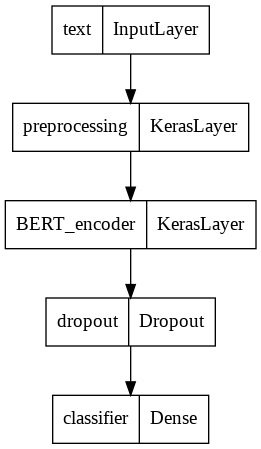

In [17]:
tf.keras.utils.plot_model(classifier_model)

Define callbacks for saving the Model state and output

In [ ]:
checkpoint_filepath = '/content/p2/MyDrive/p2/' + bert_model_name + '/checkpoint'
history_filepath = '/content/p2/MyDrive/p2/' + bert_model_name + '/history.csv'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model_history_callback = tf.keras.callbacks.CSVLogger(history_filepath)

Train the Model

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')

with tf.device('/device:GPU:0'):
  history = classifier_model.fit(x_train,
                                y_train,
                                validation_data= (x_val, y_val),
                                epochs=2,
                                batch_size=32,
                                callbacks=[model_checkpoint_callback,
                                           tf.keras.callbacks.CSVLogger(history_filepath)])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/2
9375/9375 [==============================] - 9703s 1s/step - loss: 1.0876 - accuracy: 0.5252 - val_loss: 0.8221 - val_accuracy: 0.6425
Epoch 2/2
3964/9375 [===========>..................] - ETA: 1:22:31 - loss: 0.8232 - accuracy: 0.6383

(Cont.) Train the Model

In [ ]:
with tf.device('/device:GPU:0'):
  classifier_model.load_weights(checkpoint_filepath)

  history = classifier_model.fit(x_train,
                                y_train,
                                validation_data= (x_val, y_val),
                                epochs=1,
                                batch_size=32,
                                callbacks=[model_checkpoint_callback,
                                           tf.keras.callbacks.CSVLogger(history_filepath, append=True)])

9375/9375 [==============================] - 9609s 1s/step - loss: 0.8045 - accuracy: 0.6472 - val_loss: 0.7579 - val_accuracy: 0.6705


In [ ]:
with tf.device('/device:GPU:0'):
  classifier_model.load_weights(checkpoint_filepath)

  history = classifier_model.fit(x_train,
                                y_train,
                                validation_data= (x_val, y_val),
                                epochs=1,
                                batch_size=32,
                                callbacks=[model_checkpoint_callback,
                                           tf.keras.callbacks.CSVLogger(history_filepath, append=True)])

9375/9375 [==============================] - 9650s 1s/step - loss: 0.7455 - accuracy: 0.6742 - val_loss: 0.7327 - val_accuracy: 0.6859


In [ ]:
with tf.device('/device:GPU:0'):
  classifier_model.load_weights(checkpoint_filepath)

  history = classifier_model.fit(x_train,
                                y_train,
                                validation_data= (x_val, y_val),
                                epochs=1,
                                batch_size=32,
                                callbacks=[model_checkpoint_callback,
                                           tf.keras.callbacks.CSVLogger(history_filepath, append=True)])

9375/9375 [==============================] - 6332s 673ms/step - loss: 0.7046 - accuracy: 0.6934 - val_loss: 0.7151 - val_accuracy: 0.6920


In [ ]:
with tf.device('/device:GPU:0'):
  classifier_model.load_weights(checkpoint_filepath)

  history = classifier_model.fit(x_train,
                                y_train,
                                validation_data= (x_val, y_val),
                                epochs=1,
                                batch_size=32,
                                callbacks=[model_checkpoint_callback,
                                           tf.keras.callbacks.CSVLogger(history_filepath, append=True)])

9375/9375 [==============================] - 6360s 678ms/step - loss: 0.6698 - accuracy: 0.7092 - val_loss: 0.7193 - val_accuracy: 0.6937


In [ ]:
with tf.device('/device:GPU:0'):
  classifier_model.load_weights(checkpoint_filepath)

  history = classifier_model.fit(x_train,
                                y_train,
                                validation_data= (x_val, y_val),
                                epochs=1,
                                batch_size=32,
                                callbacks=[model_checkpoint_callback,
                                           tf.keras.callbacks.CSVLogger(history_filepath, append=True)])

9375/9375 [==============================] - 6319s 674ms/step - loss: 0.6329 - accuracy: 0.7260 - val_loss: 0.7293 - val_accuracy: 0.6925


In [ ]:
with tf.device('/device:GPU:0'):
  classifier_model.load_weights(checkpoint_filepath)

  history = classifier_model.fit(x_train,
                                y_train,
                                validation_data= (x_val, y_val),
                                epochs=1,
                                batch_size=32,
                                callbacks=[model_checkpoint_callback,
                                           tf.keras.callbacks.CSVLogger(history_filepath, append=True)])

9375/9375 [==============================] - 6315s 674ms/step - loss: 0.6330 - accuracy: 0.7259 - val_loss: 0.7361 - val_accuracy: 0.6904


## Evaluate

Evaluate the trained Model with Test set

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

classifier_model.load_weights(checkpoint_filepath)

y_pred = classifier_model.predict(x_val, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_val, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_val, axis=1), y_pred)

3125/3125 [==============================] - 773s 246ms/step
              precision    recall  f1-score   support

           0     0.7445    0.8105    0.7761     11805
           1     0.5353    0.4828    0.5077      9287
           2     0.6045    0.5117    0.5543     13362
           3     0.6173    0.5493    0.5813     26144
           4     0.7720    0.8659    0.8162     39402

    accuracy                         0.6937    100000
   macro avg     0.6547    0.6441    0.6471    100000
weighted avg     0.6839    0.6937    0.6864    100000



array([[ 9568,  1643,   356,   114,   124],
       [ 2568,  4484,  1792,   351,    92],
       [  497,  2003,  6838,  3545,   479],
       [  122,   201,  2077, 14360,  9384],
       [   97,    45,   249,  4892, 34119]])

In [ ]:
y_pred = classifier_model.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_test, axis=1), y_pred)

3125/3125 [==============================] - 772s 247ms/step
              precision    recall  f1-score   support

           0     0.7461    0.8136    0.7783     11805
           1     0.5298    0.4736    0.5001      9287
           2     0.5955    0.5061    0.5472     13362
           3     0.6159    0.5494    0.5808     26145
           4     0.7728    0.8658    0.8167     39401

    accuracy                         0.6924    100000
   macro avg     0.6520    0.6417    0.6446    100000
weighted avg     0.6823    0.6924    0.6851    100000



array([[ 9604,  1643,   327,   123,   108],
       [ 2505,  4398,  1924,   380,    80],
       [  537,  2010,  6763,  3522,   530],
       [  137,   201,  2130, 14365,  9312],
       [   90,    49,   213,  4935, 34114]])